# Project Continuation
The preceding analysis, including data understanding, exploratory data analysis (EDA), and feature engineering, was conducted in a separate [notebook](https://github.com/JunGaoca/creditCardFraudDetection/blob/main/credit-card-fraud-detection.ipynb). This notebook focuses on the subsequent stages of the pipeline, specifically model development and performance evaluation.

# Data Loading - Merged Dataset

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
# Load the merged dataset
data = pd.read_csv("processed_data/txn_identity.csv")
data = data.drop(columns="Unnamed: 0")

In [38]:
data.shape

(590540, 109)

In [5]:
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_30,id_31,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,13926,-1.0,150.0,1,142.0,...,6,21,-1.0,4,2,2,2,2,1,1527
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,...,6,21,-1.0,4,2,2,2,2,1,1527
2,2987002,0,86469,59.0,4,4663,490.0,150.0,4,166.0,...,6,21,-1.0,4,2,2,2,2,1,1527
3,2987003,0,86499,50.0,4,18132,567.0,150.0,2,117.0,...,6,21,-1.0,4,2,2,2,2,1,1527
4,2987004,0,86506,50.0,1,4497,514.0,150.0,2,102.0,...,2,30,32.0,3,1,0,1,1,2,838


# Stratified Sampling

In [9]:
from sklearn.model_selection import train_test_split

# Sample 20K rows stratified on 'isFraud'
df, _ = train_test_split(data, train_size=20000, stratify=data['isFraud'], random_state=42)
df.shape

(20000, 109)

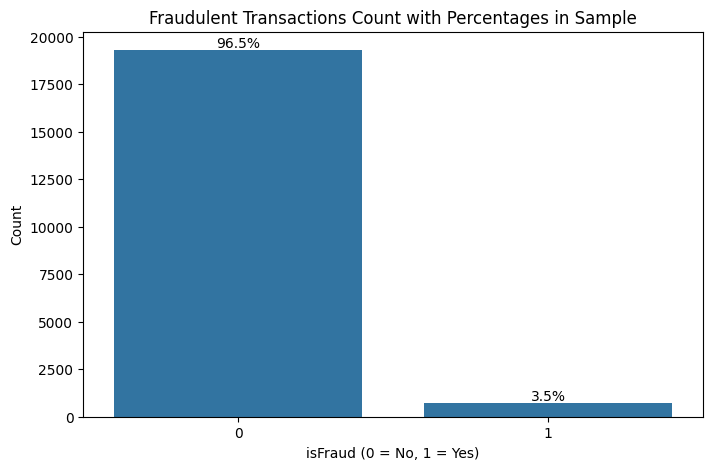

In [7]:
# Validate that class proportions are retained in the sample
plt.figure(figsize=(8,5))
ax = sns.countplot(x='isFraud', data=df)

# Calculate percentages and annotate the bars
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'  # Calculate percentage
    x = p.get_x() + p.get_width() / 2  # X position for the label
    y = p.get_height()  # Y position for the label
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10)

# Add title and labels
plt.title('Fraudulent Transactions Count with Percentages in Sample')
plt.xlabel('isFraud (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Train/Test Split

In [10]:
# Define the features (X) and the target variable (y)
X = df.drop(columns=['isFraud'])
y = df['isFraud']

In [11]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
print(f"Training set size: {X_train.shape}. Training labels size: {y_train.shape}")
print(f"Test set size: {X_test.shape}. Test labels size: {y_test.shape}")

Training set size: (16000, 108). Training labels size: (16000,)
Test set size: (4000, 108). Test labels size: (4000,)


<Figure size 600x400 with 0 Axes>

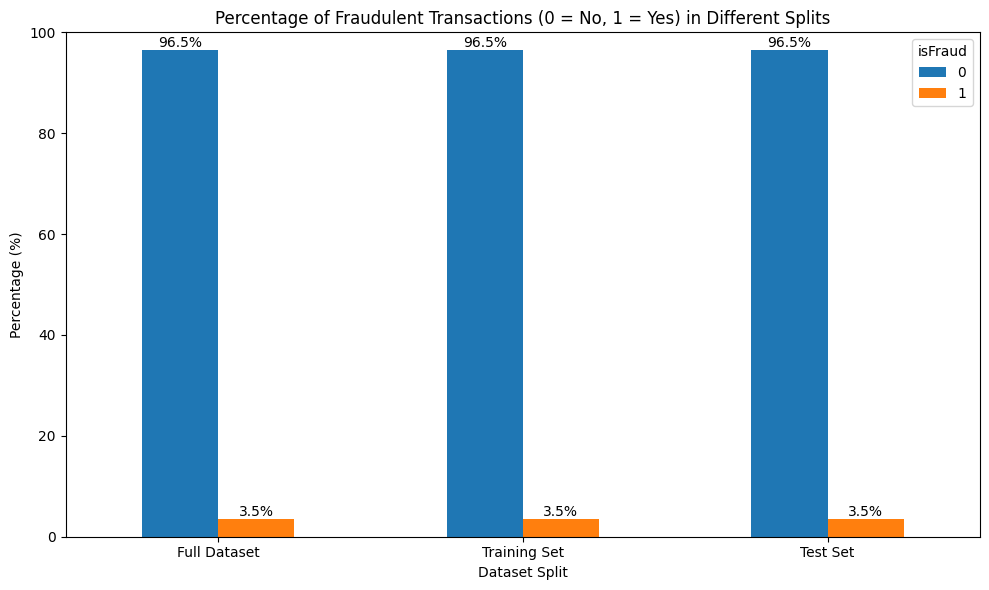

In [ ]:
y_distribution_df = pd.DataFrame({
    'Full Dataset': df['isFraud'].value_counts(normalize=True),
    'Training Set': y_train.value_counts(normalize=True),
    'Test Set': y_test.value_counts(normalize=True)
}).T * 100  # convert to percentages

plt.figure(figsize=(6, 4))
ax = y_distribution_df.plot(kind='bar', figsize=(10, 6), rot=0)

plt.title("Percentage of Fraudulent Transactions (0 = No, 1 = Yes) in Different Splits")
plt.xlabel("Dataset Split")
plt.ylabel("Percentage (%)")
plt.legend(title="isFraud")
plt.ylim(0, 100)

for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=10)

# Add space at the top of the plot
plt.subplots_adjust(top=0.8) 

plt.tight_layout()
plt.show()

# Baseline Performance

In [25]:
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [26]:
random_baseline = DummyClassifier(strategy='stratified') 
random_baseline.fit(X_train, y_train)
y_random_pred = random_baseline.predict(X_test)

Baseline accuracy: 0.94
Baseline precision: 0.03
Baseline recall: 0.03
Baseline F1: 0.03


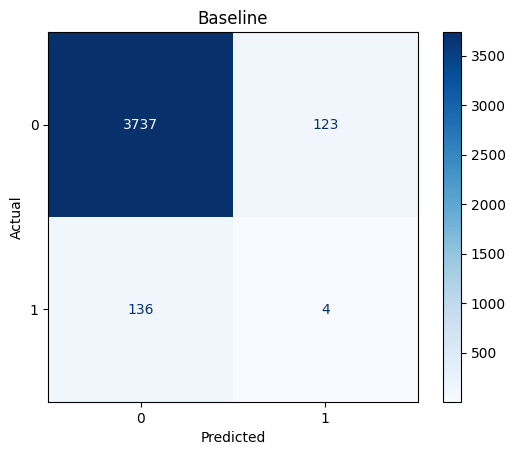

In [27]:
baseline_accuracy = accuracy_score(y_test, y_random_pred)
baseline_precision = precision_score(y_test, y_random_pred, average='binary', zero_division=0)
baseline_recall = recall_score(y_test, y_random_pred, average='binary', zero_division=0)
baseline_f1 = f1_score(y_test, y_random_pred, average='binary', zero_division=0)
cm = confusion_matrix(y_test, y_random_pred)

print(f"Baseline accuracy: {baseline_accuracy:.2f}")
print(f"Baseline precision: {baseline_precision:.2f}")
print(f"Baseline recall: {baseline_recall:.2f}")
print(f"Baseline F1: {baseline_f1:.2f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Baseline')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Decision Tree Model

In [28]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [29]:
# Create a dictionary to store metrics
results = {}

# Predict on the test set
y_pred = dt_clf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Store the results in the dictionary
results['Decision Tree'] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Confusion Matrix': confusion_mat
}

              Accuracy Precision    Recall  F1-Score
Decision Tree  0.94725  0.237037  0.228571  0.232727


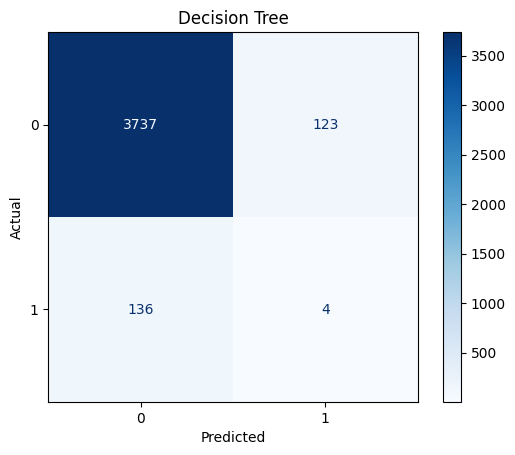

In [ ]:
# Display metrics
metrics_df = pd.DataFrame(results).T.drop(columns='Confusion Matrix')
print(metrics_df)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Class Definitions:
- **True Positive (TP)**: Correctly predicted a fraudulent transaction (prediction = 1, actual = 1).

- **True Negative (TN)**: Correctly predicted a non-fraudulent transaction (prediction = 0, actual = 0).

- **False Positive (FP)**: Incorrectly predicted a non-fraudulent transaction as fraud (prediction = 1, actual = 0).

- **False Negative (FN)**: Incorrectly predicted a fraudulent transaction as non-fraudulent (prediction = 0, actual = 0).


### Performance Analysis
While the Decision Tree model shows improvement over the DummyClassifier baseline, its overall performance remains suboptimal.

- **Accuracy (~95%)**: 

Accuracy measures the overall correctness of predictions, but in the context of fraud detection, it is misleading due to the highly imbalanced dataset (96.5% non-fraud). A model could achieve high accuracy simply by predicting most transactions as non-fraud, offering little practical value.

- **Precision(~24%)**: 

Precision reflects the proportion of transactions predicted as fraud that are actually fraudulent. In other words, of all the cases the model flags as fraud, how many are truly fraud? A low precision implies a high number of false positives, which may lead to unnecessary investigations and poor user experience. Here, only about 24% of the flagged transactions are actual frauds—meaning 76% are incorrectly classified.

- **Recall(~23%)**: 

Recall indicates the proportion of actual fraud cases that the model correctly identifies. That is, of all the fraudulent transactions, how many did we catch? This is a critical metric in fraud detection. With a recall of ~23%, the model is missing the majority of fraud cases, which poses significant financial and reputational risks for institutions.

- **F1-Score(~23%)**: 

The F1-score balances precision and recall. A low F1-score reflects that the model is not effective at distinguishing between fraud and non-fraud, resulting in poor detection performance overall.



# Balancing the Dataset

In [3]:
from imblearn.over_sampling import SMOTE # pip install imbalanced-learn
from collections import Counter

In [13]:
# Print the class distribution before balancing
print("Class distribution before SMOTE:", Counter(y_train))

Class distribution before SMOTE: Counter({0: 15440, 1: 560})


In [14]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to balance the dataset
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [15]:
# Print the class distribution after balancing
print("Class distribution after SMOTE:", Counter(y_train_balanced))

Class distribution after SMOTE: Counter({0: 15440, 1: 15440})


# Decision Tree Model with Balanced Data

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_clf_balanced = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_clf_balanced.fit(X_train_balanced, y_train_balanced)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

              Accuracy Precision    Recall  F1-Score
Decision Tree   0.9435  0.237805  0.278571  0.256579


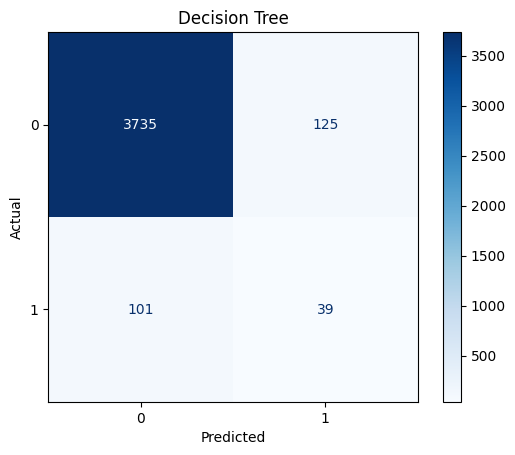

In [21]:
# Create a dictionary to store metrics
results = {}

# Predict on the test set
y_pred = dt_clf_balanced.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Store the results in the dictionary
results['Decision Tree'] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Confusion Matrix': confusion_mat
}

# Display metrics
metrics_df = pd.DataFrame(results).T.drop(columns='Confusion Matrix')
print(metrics_df)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Models

In [ ]:
%!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.0 MB/s eta 0:00:00a 0:00:010m

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
%!pip install catboost 


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 10.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [31]:
from catboost import CatBoostClassifier

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import cross_val_score, KFold

In [35]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss'), 
    'CatBoost': CatBoostClassifier(class_weights=[1, 1], silent=True)
}

In [36]:
results = []
trained_models = {}

for name, model in models.items():
    print(f"Training {name} ...")

    # Train the model on full training data and predict on the test set
    model.fit(X_train_balanced, y_train_balanced)
    y_train_pred = model.predict(X_train_balanced)
    y_test_pred = model.predict(X_test)

    # Store trained model
    trained_models[name] = model

    # Compute train metrics
    train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
    train_precision = precision_score(y_train_balanced, y_train_pred, average='binary', zero_division=0)
    train_recall = recall_score(y_train_balanced, y_train_pred, average='binary', zero_division=0)
    train_f1 = f1_score(y_train_balanced, y_train_pred, average='binary', zero_division=0)

    # Compute test metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='binary', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='binary', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='binary', zero_division=0)

    # Store results
    results.append({
        "Model": name,
        "Train Accuracy": train_accuracy,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Train F1": train_f1,
        "Test Accuracy": test_accuracy,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1": test_f1,
    })

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results).sort_values(by="Test F1", ascending=False)

Training Logistic Regression ...
Training Decision Tree ...
Training Random Forest ...
Training KNN ...
Training Gradient Boosting ...
Training XGBoost ...
Training CatBoost ...


In [37]:
results_df

,Model,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
5,XGBoost,0.996665,0.999935,0.993394,0.996654,0.97050,0.711538,0.264286,0.385417
6,CatBoost,0.993264,0.999738,0.986788,0.993220,0.97000,0.738095,0.221429,0.340659
4,Gradient Boosting,0.978206,0.990957,0.965220,0.977919,0.96175,0.417722,0.235714,0.301370
2,Random Forest,1.000000,1.000000,1.000000,1.000000,0.96825,0.685714,0.171429,0.274286
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,0.94350,0.237805,0.278571,0.256579
0,Logistic Regression,0.698251,0.729977,0.629275,0.675896,0.73775,0.070822,0.535714,0.125104
3,KNN,0.885557,0.858658,0.923057,0.889693,0.76500,0.058499,0.378571,0.101338


# Hyperparameter Tuning and Cross-Validation

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

In [56]:
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']

    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'XGBoost': {
        'n_estimators': [100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6, 10],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1]
    },
    'CatBoost': {
        'iterations': [100],
        'learning_rate': [0.01, 0.1],
        'depth': [4, 6, 10]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 10]
    }
}

In [57]:
# Initialize the best models dictionary
best_models = {}

# Perform grid search for each model
for model_name, params in param_grids.items():
    print(f"Tuning {model_name}...")
    if model_name == 'Logistic Regression':
        model = LogisticRegression(class_weight='balanced', random_state=42)
    elif model_name == 'Decision Tree':
        model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(class_weight='balanced', random_state=42)
    elif model_name == 'KNN':
        model = KNeighborsClassifier()
    elif model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier()
    elif model_name == 'XGBoost':
        model = XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss')
    elif model_name == 'CatBoost':
        model = CatBoostClassifier(class_weights=[1, 1], silent=True)
    

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='f1',
        cv=5,
        verbose=1
    )

    # Fit the grid search
    grid_search.fit(X_train_balanced, y_train_balanced)

    # Store the best model
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best F1 score for {model_name}: {grid_search.best_score_}\n")

Tuning Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'C': 100, 'solver': 'liblinear'}
Best F1 score for Logistic Regression: 0.7038715034160172

Tuning Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Decision Tree: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best F1 score for Decision Tree: 0.9703286199807166

Tuning KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best F1 score for KNN: 0.8719885446451435

Tuning XGBoost...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Best F1 score for XGBoost: 0.9836662362387317

Tuning CatBoost...
Fitting 5 folds for each of 6 candidates, totall

In [58]:
# Evaluate the best models on the test set
results_tuned = {}

for model_name, model in best_models.items():
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Store the results
    results_tuned[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix': confusion_mat
    }

# Display the tuned results
metrics_df_tuned = pd.DataFrame(results_tuned).T.drop(columns='Confusion Matrix')
metrics_df_tuned = metrics_df_tuned.sort_values(['F1-Score'], ascending=False)

#print("\nTuned Model Metrics:")
print(metrics_df_tuned)

                    Accuracy Precision    Recall  F1-Score
CatBoost              0.9675  0.580645  0.257143  0.356436
XGBoost              0.96975  0.711111  0.228571  0.345946
Gradient Boosting      0.968      0.62  0.221429  0.326316
Random Forest         0.9675   0.65625      0.15  0.244186
Decision Tree          0.953  0.273585  0.207143  0.235772
Logistic Regression   0.7675  0.084211  0.571429  0.146789
KNN                    0.791  0.066085  0.378571  0.112527


# Evaluations and Recommendations

### Evaluations
- Best F1-Score (Balanced Performance):
CatBoost (0.36) and XGBoost (0.35) — best overall trade-off between precision and recall.

- Best Precision:
XGBoost (0.71) — great at minimizing false positives.

- Best Recall:
Logistic Regression (0.57) — best at catching fraud but extremely poor precision and F1-Score, meaning it has lots of false positives.

### Business Insights
1.	CatBoost and XGBoost offer the best trade-off between catching fraud (recall) and avoiding false alarms (precision), achieving the highest F1-scores.

2.	Logistic Regression and KNN have high recall but unacceptably low precision, leading to many false positives, which could result in poor customer experience and increased manual review cost and operational overhead.

### Business Recommendations
1. Deploy XGBoost or CatBoost in production, as these models balance fraud detection and user experience better than others.

2. Use Logistic Regression as a secondary monitoring tool, utilizing its high recall to flag potential fraud cases that other models might miss.

3. Implement continuous monitoring of false positives and false negatives to refine model performance and reduce operational risk over time.



# Next Steps
1. Further refine CatBoost/XGBoost with grid or randomized search to enhance recall while maintaining acceptable precision.

2. Leverage ensemble or stacking methods to improve recall and model robustness by capturing a wider variety of fraud patterns.

3. Investigate deep learning approaches to further boost the performance and adaptability of the fraud detection pipeline.